Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'supervisor': Node(id='supervisor', name='supervisor', data=supervisor(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'math_node': Node(id='math_node', name='math_node', data=math_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'search_node': Node(id='search_node', name='search_node', data=search_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'farewell': Node(id='farewell', name='farewell', data=farewell(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', t

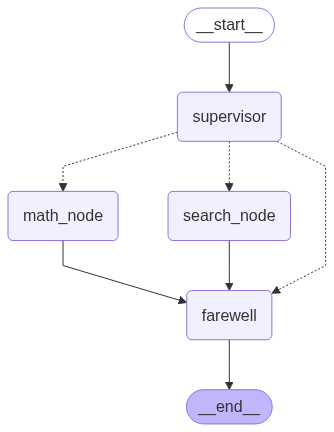

Supervisor Node
Next: math_node
Why: User asked for a math calculation
Math Node
Farewell Node

--- Conversation ---
HumanMessage: What's 15*9?
AIMessage: The answer is: 135
AIMessage: Goodbye!


In [1]:
import os
import operator
import re
from typing import TypedDict, Literal, Annotated
import langgraph
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END
from pydantic import BaseModel

# ---------------------------------------------
# STEP 1: Agent State
# ---------------------------------------------
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]
    step: str

# ---------------------------------------------
# STEP 2: Groq Model
# ---------------------------------------------
groq_model = ChatGroq(
    model="llama3-70b-8192",
    temperature=0.2,
    api_key=os.getenv("GROQ_API_KEY")
)

# ---------------------------------------------
# STEP 3: Tools
# ---------------------------------------------
@tool
def calculator(expression: str) -> str:
    """Evaluates a basic math expression like '2 + 2'."""
    try:
        math_pattern = r'(\d+(?:\.\d+)?)\s*([+\-*/])\s*(\d+(?:\.\d+)?)'
        match = re.search(math_pattern, expression)
        if match:
            num1, operator_, num2 = match.groups()
            result = eval(f"{num1} {operator_} {num2}")
            return str(int(result) if result == int(result) else result)
        return "Could not parse expression"
    except Exception as e:
        return f"Error: {str(e)}"

try:
    tavily_search = TavilySearchResults(
        max_results=3,
        search_depth="advanced",
        tavily_api_key=os.getenv("TAVILY_API_KEY")
    )
    TAVILY_AVAILABLE = True
except Exception as e:
    print(f"⚠️ Tavily not available: {e}")
    TAVILY_AVAILABLE = False

@tool
def fallback_search(query: str) -> str:
    """Fallback search when Tavily API key is missing."""
    return f"I would search for '{query}' but Tavily API key is not configured."

# ---------------------------------------------
# STEP 4: Router Schema
# ---------------------------------------------
ROUTER_PROMPT = """
Classify the user's input and pick one category:
- 'math_node' for math calculations (e.g., contains +, -, *, / or numbers)
- 'search_node' for questions that need web search (current events, info lookup)
- 'farewell' if user says bye or thanks

Respond in JSON:
{"next": "<node>", "reasoning": "<why>"}
"""

class Router(BaseModel):
    next: Literal["search_node", "math_node", "farewell"]
    reasoning: str

# ---------------------------------------------
# STEP 5: Nodes
# ---------------------------------------------
def supervisor_node(state: AgentState):
    print("Supervisor Node")
    messages = [
        SystemMessage(content=ROUTER_PROMPT),
        HumanMessage(content=state["messages"][-1].content)
    ]
    response = groq_model.with_structured_output(Router).invoke(messages)
    print("Next:", response.next)
    print("Why:", response.reasoning)
    return {"step": response.next}

def math_node(state: AgentState):
    print("Math Node")
    query = state["messages"][-1].content
    result = calculator.invoke({"expression": query})
    response = f"The answer is: {result}" if "Error" not in result else result
    return {"messages": [AIMessage(content=response)], "step": "farewell"}

def search_node(state: AgentState):
    print("Search Node")
    query = state["messages"][-1].content
    if not TAVILY_AVAILABLE:
        result = fallback_search.invoke({"query": query})
        return {"messages": [AIMessage(content=result)], "step": "farewell"}
    try:
        results = tavily_search.invoke({"query": query})
        if results:
            response = "Here's what I found:\n\n"
            for i, r in enumerate(results[:2], 1):
                title = r.get('title', 'No title')
                content = r.get('content', 'No content available')[:200]
                url = r.get('url', '')
                response += f"{i}. {title}\n   {content}...\n   Source: {url}\n\n"
        else:
            response = "No results found."
    except Exception as e:
        response = f"Error searching: {str(e)}"
    return {"messages": [AIMessage(content=response)], "step": "farewell"}

def farewell_node(state: AgentState):
    print("Farewell Node")
    return {"messages": [AIMessage(content="Goodbye!")]}  # End message

# ---------------------------------------------
# STEP 6: LangGraph Setup
# ---------------------------------------------
def route_supervisor(state: AgentState):
    return state["step"]

graph = StateGraph(AgentState)
graph.set_entry_point("supervisor")
graph.add_node("supervisor", supervisor_node)
graph.add_node("math_node", math_node)
graph.add_node("search_node", search_node)
graph.add_node("farewell", farewell_node)

graph.add_conditional_edges(
    "supervisor", route_supervisor,
    {
        "math_node": "math_node",
        "search_node": "search_node",
        "farewell": "farewell"
    }
)
graph.add_edge("math_node", "farewell")
graph.add_edge("search_node", "farewell")
graph.add_edge("farewell", END)

app = graph.compile()

graph = app.get_graph()
print(graph)
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

# ---------------------------------------------
# STEP 7: Example Run
# ---------------------------------------------

# initial_state = {
#     "messages": [HumanMessage(content="What's the latest news about AI?")],
#     "step": "supervisor"
# }

initial_state = {
    "messages": [HumanMessage(content="What's 15*9?")],
    "step": "supervisor"
}

result = app.invoke(initial_state)

# ---------------------------------------------
# STEP 8: Show Output
# ---------------------------------------------
print("\n--- Conversation ---")
for msg in result["messages"]:
    print(f"{msg.__class__.__name__}: {msg.content}")
